# Figures

## SODA

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
wmt_budget_terms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/wmt_budget_terms.zarr'))
wmt_budget_terms#.load()

<xarray.Dataset>
Dimensions:         (time: 985, sigma2_bin: 699)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    omega_trans     (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    psi_vel         (time, sigma2_bin) float32 dask.array<chunksize=(247, 350), meta=np.ndarray>
    u_binned_left   (time, sigma2_bin) float32 dask.array<chunksize=(247, 350), meta=np.ndarray>
    u_binned_right  (time, sigma2_bin) float32 dask.array<chunksize=(247, 350), meta=np.ndarray>
    v_binned        (time, sigma2_bin) float32 dask.array<chunksize=(247, 350), meta=np.ndarray>

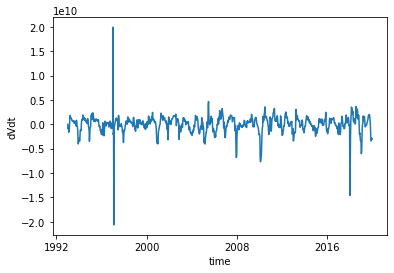

In [4]:
#spike caused by jump in salinity from nudging
wmt_budget_terms.dVdt.sum('sigma2_bin').plot()

In [5]:
#Converting time from Julian to datetime64[ns] object
datetimeindex = wmt_budget_terms.indexes['time'].to_datetimeindex()
wmt_budget_terms['time'] = datetimeindex

/tmp/ipykernel_349/3295612590.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = wmt_budget_terms.indexes['time'].to_datetimeindex()


In [6]:
wmt_budget_terms.load()

<xarray.Dataset>
Dimensions:         (time: 985, sigma2_bin: 699)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T...
Data variables:
    dVdt            (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_trans     (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    psi_vel         (time, sigma2_bin) float32 -1.351 -1.351 ... -0.0 -0.0
    u_binned_left   (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u_binned_right  (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v_binned        (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

## Time mean budgets

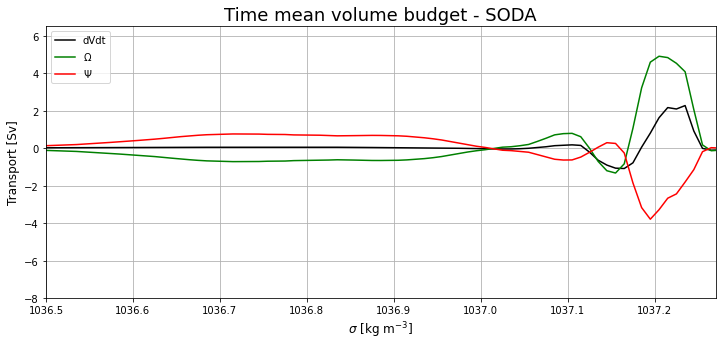

In [7]:
plt.figure(figsize=(12,5))
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dVdt', color='k')
wmt_budget_terms.omega_trans.mean(dim='time').plot(label=r'$\Omega$', color='green')
wmt_budget_terms.psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red')
plt.grid()
plt.legend()
plt.ylim(-8,6.5)
plt.xlim(1036.5, 1037.27)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
#plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);
plt.title('Time mean volume budget - SODA', fontsize=18);

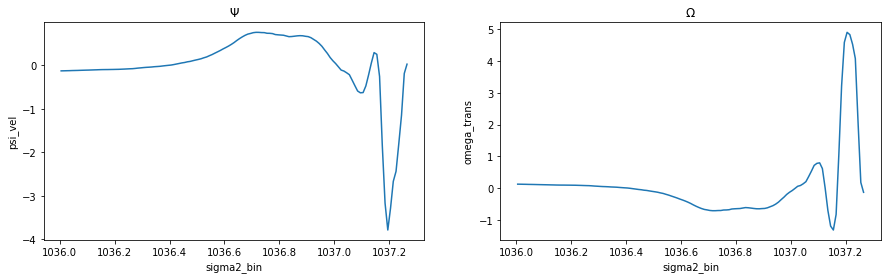

In [8]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1036.0, 1037.27)).plot(ax=ax0)
wmt_budget_terms.omega_trans.mean('time').sel(sigma2_bin=slice(1036.0, 1037.27)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

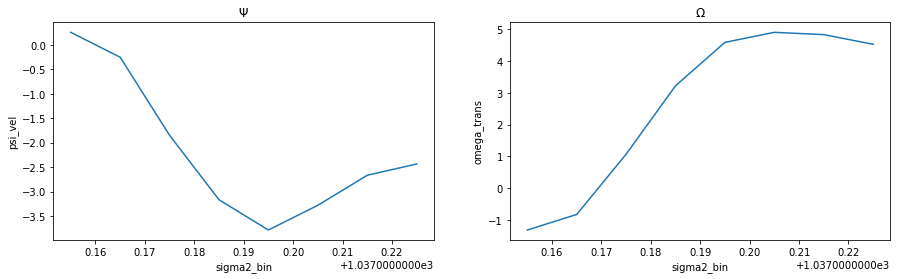

In [9]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.15, 1037.23)).plot(ax=ax0)
wmt_budget_terms.omega_trans.mean('time').sel(sigma2_bin=slice(1037.15, 1037.23)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

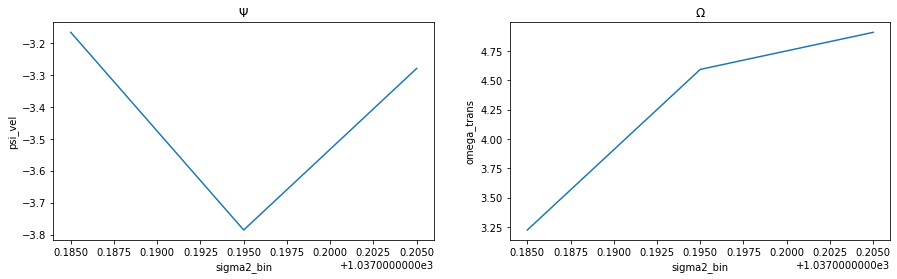

In [10]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.18, 1037.21)).plot(ax=ax0)
wmt_budget_terms.omega_trans.mean('time').sel(sigma2_bin=slice(1037.18, 1037.21)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

### $\frac{\partial V}{\partial t}$

In [11]:
bottom = (wmt_budget_terms.mean('time').isel(sigma2_bin=-1) - 
          wmt_budget_terms.mean('time').sel(sigma2_bin=1037.195, method='nearest'))
deep = (wmt_budget_terms.mean('time').sel(sigma2_bin=1037.195, method='nearest') - 
        wmt_budget_terms.mean('time').isel(sigma2_bin=0))

In [12]:
print('BOTTOM dvdt:', bottom.dVdt.values/1e6, ' psi:', bottom.psi_vel.values, ' omega:', bottom.omega_trans.values)

BOTTOM dvdt: -0.8075855657792477  psi: 3.785455  omega: -4.592361153713793


In [13]:
print('DEEP dvdt:', deep.dVdt.values/1e6, ' psi:', deep.psi_vel.values, ' omega:', deep.omega_trans.values)

DEEP dvdt: 0.8075855657793182  psi: -3.6492794  omega: 4.457420538059121


__SWITCH SIGN OF ALL TERMS__

* $\frac{\partial V}{\partial t}$ is (+ to -) for bottom wm, (- to +) for deep wm
   * (No longer cumulative volume!) Decreasing rate of volume means less water in wm; conversely, increasing rate of volume means more water in wm.
* $\Psi$ is (+ to -) for bottom wm, (- to +) for deep wm
   * Negative $\Psi$ means OUTflow, positive $\Psi$ means INflow
* $\Omega$ is (- to +) for bottom wm, (+ to -) for deep wm
   * using only one $\Omega$ (on the boundary) yields a positive value, which means positive transformation of deep layer water being added to bottom layer. (+) into layer 2 (bottom) is trying to add volume, (-) from layer 1 (deep) is trying to remove volume.

In [14]:
bottom = -bottom
deep = -deep

In [15]:
print('BOTTOM correct dvdt:', bottom.dVdt.values/1e6, ' correct psi:', bottom.psi_vel.values, ' correct omega:', bottom.omega_trans.values)

BOTTOM correct dvdt: 0.8075855657792477  correct psi: -3.785455  correct omega: 4.592361153713793


In [16]:
print('DEEP correct dvdt:', deep.dVdt.values/1e6, ' correct psi:', deep.psi_vel.values, ' correct omega:', deep.omega_trans.values)

DEEP correct dvdt: -0.8075855657793182  correct psi: 3.6492794  correct omega: -4.457420538059121


### $\Psi$

In [17]:
bottom.psi_vel + deep.psi_vel

<xarray.DataArray 'psi_vel' ()>
array(-0.13617563, dtype=float32)

In [18]:
bottom.psi_vel

<xarray.DataArray 'psi_vel' ()>
array(-3.785455, dtype=float32)

### $\Omega$

In [19]:
bottom.omega_trans + deep.omega_trans

<xarray.DataArray 'omega_trans' ()>
array(0.13494062)

In [20]:
bottom.omega_trans

<xarray.DataArray 'omega_trans' ()>
array(4.59236115)

In [21]:
omega_bdy = wmt_budget_terms.omega_trans.sel(sigma2_bin=1037.195, method='nearest')

In [22]:
omega_bdy_mean = omega_bdy.mean('time').load()

In [23]:
omega_bdy_mean

<xarray.DataArray 'omega_trans' ()>
array(4.59236115)
Coordinates:
    sigma2_bin  float64 1.037e+03

### Budget

In [24]:
-(bottom.dVdt/1e6) + bottom.psi_vel + bottom.omega_trans

<xarray.DataArray ()>
array(-0.0006794)

In [25]:
-(bottom.dVdt/1e6) + bottom.psi_vel + omega_bdy_mean

<xarray.DataArray ()>
array(-0.0006794)
Coordinates:
    sigma2_bin  float64 1.037e+03

In [26]:
-(deep.dVdt/1e6) + deep.psi_vel + deep.omega_trans

<xarray.DataArray ()>
array(-0.00055562)

In [27]:
-(deep.dVdt/1e6) + deep.psi_vel - omega_bdy_mean

<xarray.DataArray ()>
array(-0.13549623)
Coordinates:
    sigma2_bin  float64 1.037e+03

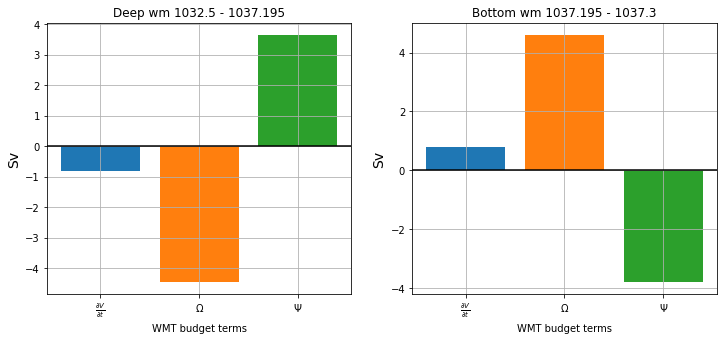

In [28]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt/1e6)
ax0.bar(x=r'$\Omega$', height = deep.omega_trans)
ax0.bar(x=r'$\Psi$', height= deep.psi_vel)
ax0.axhline(y=0, color='k')
ax0.set_title('Deep wm 1032.5 - 1037.195')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms')
ax0.grid()
#ax0.set_ylim(-0.03, -0.1)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt/1e6)
ax1.bar(x=r'$\Omega$', height = bottom.omega_trans)
ax1.bar(x=r'$\Psi$', height= bottom.psi_vel)
ax1.axhline(y=0, color='k')
ax1.set_title('Bottom wm 1037.195 - 1037.3')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms')
ax1.grid()
#ax1.set_ylim(-0.1, 0.1);

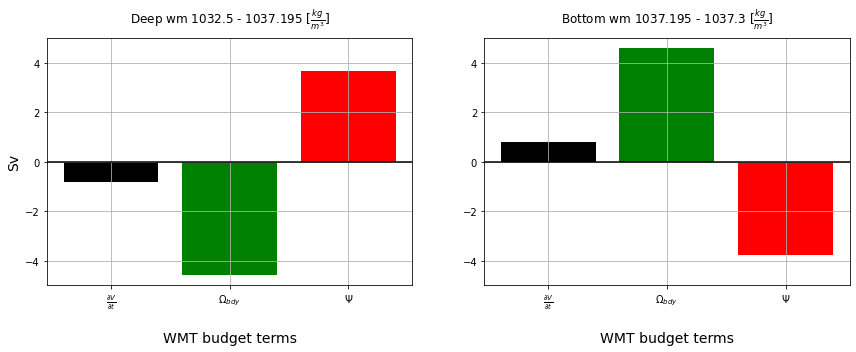

In [29]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt/1e6, color='k')
ax0.bar(x=r'$\Omega_{bdy}$', height = - omega_bdy_mean, color='green')
ax0.bar(x=r'$\Psi$', height= deep.psi_vel, color='red')
ax0.axhline(y=0, color='k')
ax0.set_title(r'Deep wm 1032.5 - 1037.195 [$\frac{kg}{m^3}$]', pad=15)
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax0.grid()
ax0.set_ylim(-5,5)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt/1e6, color='k')
ax1.bar(x=r'$\Omega_{bdy}$', height = omega_bdy_mean, color='green')
ax1.bar(x=r'$\Psi$', height= bottom.psi_vel, color='red')
ax1.axhline(y=0, color='k')
ax1.set_title(r'Bottom wm 1037.195 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
#ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax1.grid()
ax1.set_ylim(-5,5)

plt.tight_layout(w_pad=5);

> DEEP: Inflow, transformation is stronger and is making wm lose volume on avg. Net vol loss - not consistent with `wmt-budget-sigma-space-cleaned.ipynb`. CHECK AGAIN, RYAN SHOWED A DIFF CALCULATION FOR VOL GAIN/LOSS IN ECCO OR SOSE NB (1.27.21)

> BOTTOM: Outflow not as strong as positive transformation adding volume to wm. Net vol gain - not consistent with `wmt-budget-sigma-space-cleaned.ipynb` which shows net loss

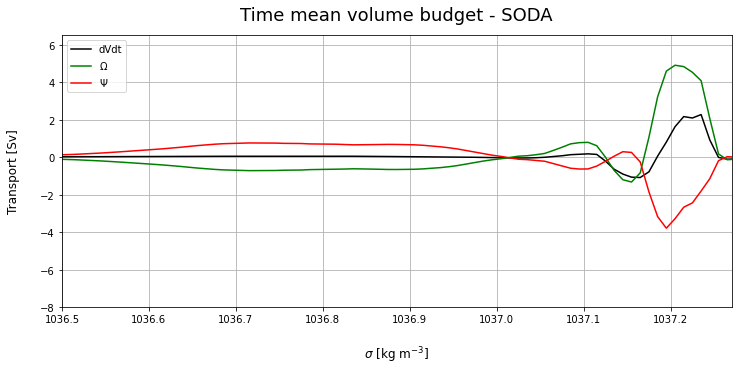

In [30]:
plt.figure(figsize=(12,5))
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dVdt', color='k')
wmt_budget_terms.omega_trans.mean(dim='time').plot(label=r'$\Omega$', color='green')
wmt_budget_terms.psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red')
plt.grid()
plt.legend()
plt.ylim(-8,6.5)
plt.xlim(1036.5, 1037.27)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12, labelpad=20)
plt.ylabel(r'Transport [Sv]', fontsize=12, labelpad=20)
#plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);
plt.title('Time mean volume budget - SODA', fontsize=18, pad=15);

## Monthly Climatology

In [31]:
def anomaly(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    anom_chunk = anom.chunk({'time':-1, 'sigma2_bin':-1})
    anom_rolled = anom_chunk.rolling(time=36).mean(dim='time') #annual rolling mean to remove seasonal cycle
    return anom_rolled

In [32]:
anom_ds = xr.merge([wmt_budget_terms.dVdt.rename('dVdt'),
                    wmt_budget_terms.psi_vel.rename('psi_vel'),
                    wmt_budget_terms.omega_trans.rename('omega_trans')])


In [33]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [34]:
clim_ds = anom_ds

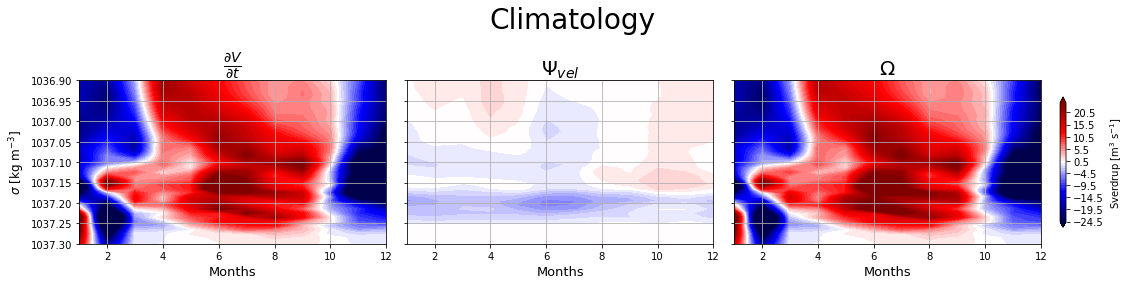

In [35]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-25, 25) + 0.5

dVdt_clim = clim(clim_ds.dVdt) / 1e6
c = ax0.contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin, 
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax0.set_xlabel('Months', fontsize=13)
ax0.set_ylim(1037.3, 1036.9)
#ax[0,0].set_xlim(xmin='1993')
ax0.grid()

psi_vel_clim = clim(clim_ds.psi_vel)
c_psi = ax1.contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20)
ax1.set_xlabel('Months', fontsize=13)
#ax1.set_ylim(1037.3, 1035.5)
#ax[0,1].set_xlim(xmin='1993')
ax1.grid()

omega_clim = clim(clim_ds.omega_trans)
c_omega = ax2.contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20)
ax2.set_xlabel('Months', fontsize=13)
#ax2.set_ylim(1037.3, 1035.5)
#ax[0,2].set_xlim(xmin='1993')
ax2.grid()

plt.suptitle('Climatology', fontsize=28)
plt.tight_layout();

## BOTTOM Monthly Climatology

In [36]:
def anomaly(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':-1, 'sigma2_bin':-1})
    anom_rolled = anom.rolling(time=36).mean(dim='time') #annual rolling mean to remove seasonal cycle
    return anom_rolled

In [37]:
#1037.185 to include 1037.195 when slicing
anom_ds = (wmt_budget_terms.sel(sigma2_bin=slice(1037.185, 1039)))

In [38]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [39]:
clim_ds = anom_ds

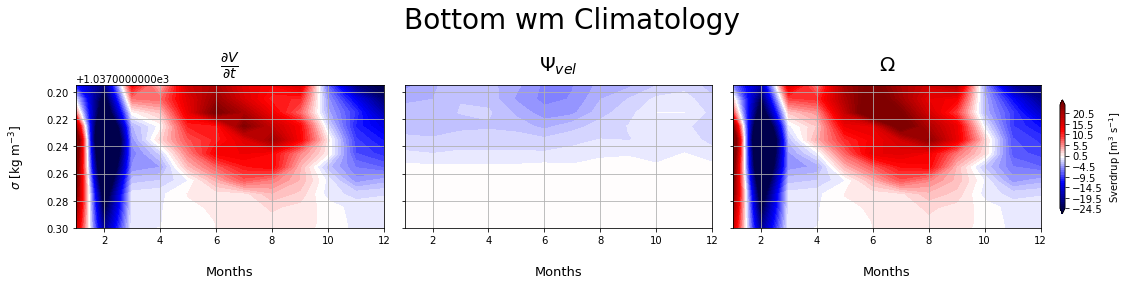

In [40]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-25, 25) + 0.5

dVdt_clim = clim(clim_ds.dVdt) / 1e6
c = ax0.contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin, 
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12, labelpad=20)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
ax0.set_xlabel('Months', fontsize=13, labelpad=20)
ax0.set_ylim(1037.3, 1037.195)
#ax[0,0].set_xlim(xmin='1993')
ax0.grid()

psi_vel_clim = clim(clim_ds.psi_vel)
c_psi = ax1.contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
ax1.set_xlabel('Months', fontsize=13, labelpad=20)
#ax1.set_ylim(1037.3, 1035.5)
#ax[0,1].set_xlim(xmin='1993')
ax1.grid()

omega_clim = clim(clim_ds.omega_trans)
c_omega = ax2.contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20, pad=15)
ax2.set_xlabel('Months', fontsize=13, labelpad=20)
#ax2.set_ylim(1037.3, 1035.5)
#ax[0,2].set_xlim(xmin='1993')
ax2.grid()

plt.suptitle('Bottom wm Climatology', fontsize=28)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [41]:
#remember we are switching signs!
dVdt_clim_bot = - dVdt_clim.isel(sigma2_bin=-1) + dVdt_clim.sel(sigma2_bin=1037.195, method='nearest')
dVdt_clim_bot.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([-11.3445492 , -22.46668299,  12.29306376,   3.2677585 ,
        16.90004538,  20.09433972,  14.84905936,  12.52694787,
        15.57210751,  -7.57148365, -21.33960359, -25.43342931])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

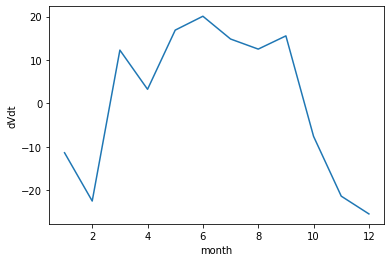

In [42]:
dVdt_clim_bot.plot()

### $\Psi$

In [43]:
#remember we are switching signs!
psi_clim_bot = - psi_vel_clim.isel(sigma2_bin=-1) + psi_vel_clim.sel(sigma2_bin=1037.195, method='nearest')
psi_clim_bot.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([-4.872194 , -3.6907272, -2.7994165, -3.114086 , -4.262149 ,
       -5.7586675, -5.5458555, -4.181609 , -3.754387 , -2.5235293,
       -1.8622106, -2.9681952], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

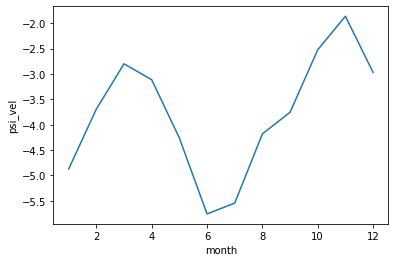

In [44]:
psi_clim_bot.plot();

### $\Omega$

In [45]:
omega_clim_bot = clim(omega_bdy)
omega_clim_bot.load()

<xarray.DataArray 'omega_trans' (month: 12)>
array([ -6.46738409, -18.77595488,  15.09248019,   6.38184474,
        21.16219285,  25.85300656,  20.39491636,  16.70855797,
        19.32649358,  -5.04795467, -19.47739292, -22.46523408])
Coordinates:
    sigma2_bin  float64 1.037e+03
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

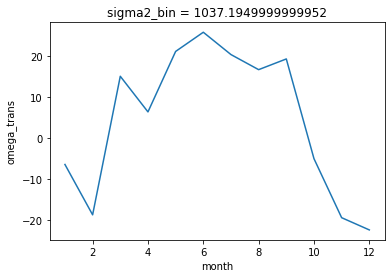

In [46]:
omega_clim_bot.plot();

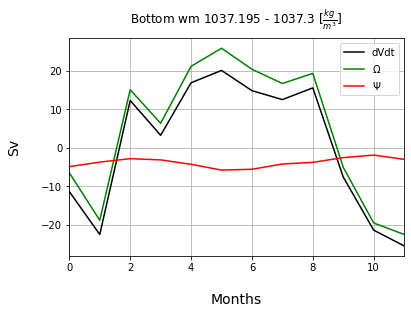

In [47]:
fig, ax1 = plt.subplots()
ax1.plot(dVdt_clim_bot, label='dVdt', color='k')
ax1.plot(omega_clim_bot, label=r'$\Omega$', color='green')
ax1.plot(psi_clim_bot, label=r'$\Psi$', color='red')
ax1.set_title(r'Bottom wm 1037.195 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
ax1.set_ylabel('Sv', fontsize=14, labelpad=20)
ax1.set_xlabel('Months', fontsize=14, labelpad=20)
ax1.set_xlim(0, 11)
plt.legend()
plt.grid();

In [48]:
- dVdt_clim_bot + psi_clim_bot + omega_clim_bot

<xarray.DataArray (month: 12)>
array([ 4.97129134e-03,  8.76815697e-07, -1.07719238e-07,  3.20834879e-07,
       -1.39124253e-06, -6.26952556e-07,  1.48195596e-06,  9.40748006e-07,
       -8.31521586e-07, -3.15258303e-07,  3.90005752e-08,  2.39872335e-08])
Coordinates:
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    sigma2_bin  float64 1.037e+03

In [49]:
(- dVdt_clim_bot + psi_clim_bot + omega_clim_bot).mean('month')

<xarray.DataArray ()>
array(0.00041431)
Coordinates:
    sigma2_bin  float64 1.037e+03

## Anomaly

In [50]:
anom = anom(anom_ds)

NameError: name 'anom' is not defined

In [ ]:
year_start_index = [0, 36, 73, 109, 146, 182, 219, 255, 292, 329, 
                    365, 402, 438, 475, 511, 548, 584, 621, 657, 
                    694, 730, 767, 803, 840, 876, 913, 949]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 5), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})#, sharex=True)

#ax00 = ax0.twinx()
#ax10 = ax1.twinx()
#ax20 = ax2.twinx()

dVdt_anom_rolled = anom.dVdt/1e6
c = ax0.pcolormesh(dVdt_anom_rolled.time, 
                   dVdt_anom_rolled.sigma2_bin, 
                   dVdt_anom_rolled.T, vmin=-20, vmax=20, cmap='seismic')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax0.set_ylim(1037.3, 1036.9)
ax0.set_xticks(dVdt_anom_rolled.time.values[year_start_index])
ax0.set_xticklabels(ax0.get_xticks(), rotation = 45)
ax0.set_xticklabels([str(i) for i in np.arange(1993, 2020)], rotation = 45)
ax0.set_xlabel('Time', fontsize=13)
#ax00.plot(sam.time.isel(index=slice(49, 54)), sam.ANN.isel(index=slice(49, 54)))
#ax00.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax0.grid()

psi_vel_anom_rolled = anom.psi_vel
c_psi = ax1.pcolormesh(psi_vel_anom_rolled.time, psi_vel_anom_rolled.sigma2_bin, psi_vel_anom_rolled.T,
                        vmin=-20, vmax=20, cmap='seismic')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20)
#ax1.set_ylim(1037.3, 1036.5)
ax1.set_xticks(psi_vel_anom_rolled.time.values[year_start_index])
ax1.set_xticklabels([str(i) for i in np.arange(1993, 2020)], rotation = 45)
ax1.set_xlabel('Time', fontsize=13)
#ax10.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax1.grid()

omega_anom_rolled = anom.omega_trans
c_omega = ax2.pcolormesh(omega_anom_rolled.time, omega_anom_rolled.sigma2_bin, omega_anom_rolled.T,
                        vmin=-20, vmax=20, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20)
#ax2.set_ylim(1037.3, 1036.5)
ax2.set_xticks(omega_anom_rolled.time.values[year_start_index])
ax2.set_xticklabels([str(i) for i in np.arange(1993, 2020)], rotation = 45)
ax2.set_xlabel('Time', fontsize=13)
#ax20.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax2.grid()

plt.suptitle('Anomalous WMT budget - SODA', fontsize=28)
plt.tight_layout();

## Bottom Anomaly

In [51]:
anom = anomaly(anom_ds)

In [52]:
year_start_index = [0, 36, 73, 109, 146, 182, 219, 255, 292, 329, 
                    365, 402, 438, 475, 511, 548, 584, 621, 657, 
                    694, 730, 767, 803, 840, 876, 913, 949]

In [53]:
import warnings
warnings.filterwarnings("ignore")

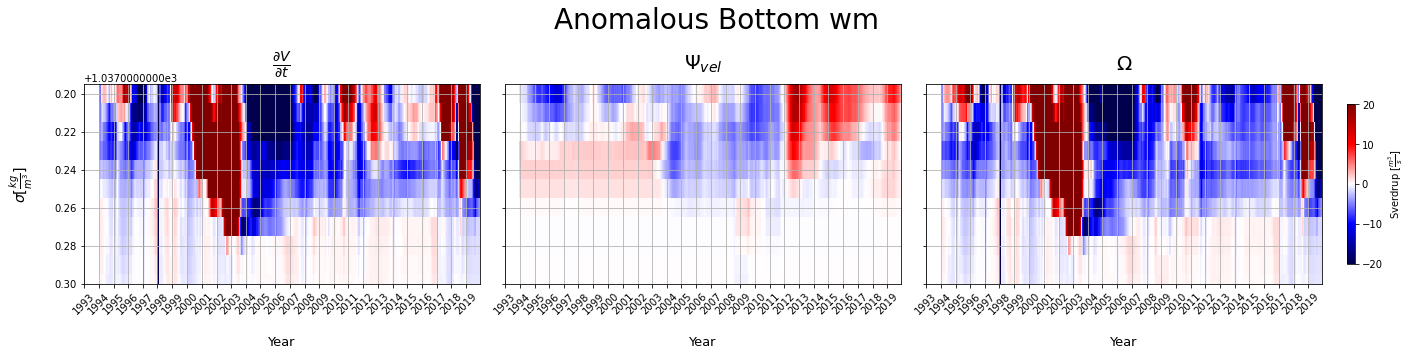

In [54]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 5), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})#, sharex=True)

#ax00 = ax0.twinx()
#ax10 = ax1.twinx()
#ax20 = ax2.twinx()

dVdt_anom_rolled = anom.dVdt/1e6
c = ax0.pcolormesh(dVdt_anom_rolled.time, 
                   dVdt_anom_rolled.sigma2_bin, 
                   dVdt_anom_rolled.T, vmin=-20, vmax=20, cmap='seismic')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14, labelpad=20)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
ax0.set_ylim(1037.3, 1037.195)
ax0.set_xticks(dVdt_anom_rolled.time.values[year_start_index])
ax0.set_xticklabels(ax0.get_xticks(), rotation = 45)
ax0.set_xticklabels([str(i) for i in np.arange(1993, 2020)], rotation = 45)
ax0.set_xlabel('Year', fontsize=13, labelpad=20)
#ax00.plot(sam.time.isel(index=slice(49, 54)), sam.ANN.isel(index=slice(49, 54)))
#ax00.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax0.grid()

psi_vel_anom_rolled = anom.psi_vel
c_psi = ax1.pcolormesh(psi_vel_anom_rolled.time, psi_vel_anom_rolled.sigma2_bin, psi_vel_anom_rolled.T,
                        vmin=-20, vmax=20, cmap='seismic')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
#ax1.set_ylim(1037.3, 1036.5)
ax1.set_xticks(psi_vel_anom_rolled.time.values[year_start_index])
ax1.set_xticklabels([str(i) for i in np.arange(1993, 2020)], rotation = 45)
ax1.set_xlabel('Year', fontsize=13, labelpad=20)
#ax10.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax1.grid()

omega_anom_rolled = anom.omega_trans
c_omega = ax2.pcolormesh(omega_anom_rolled.time, omega_anom_rolled.sigma2_bin, omega_anom_rolled.T,
                        vmin=-20, vmax=20, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20, pad=15)
#ax2.set_ylim(1037.3, 1036.5)
ax2.set_xticks(omega_anom_rolled.time.values[year_start_index])
ax2.set_xticklabels([str(i) for i in np.arange(1993, 2020)], rotation = 45)
ax2.set_xlabel('Year', fontsize=13, labelpad=20)
#ax20.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax2.grid()

plt.suptitle('Anomalous Bottom wm', fontsize=28)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [55]:
#remember we're switching signs!
dVdt_anom_bot = - anom.dVdt.isel(sigma2_bin=-1) + anom.dVdt.sel(sigma2_bin=1037.195, method='nearest')
dVdt_anom_bot.load()

<xarray.DataArray 'dVdt' (time: 985)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -9.64231841e+06, -9.13432342e+06, -8.39214270e+06, -7.19499833e+06,
       -5.49244555e+06, -3.93578433e+06, -2.39130679e+06, -7.36813670e+05,
        8.54887307e+05,  1.78587948e+06,  2.51033211e+06,  2.48301049e+06,
        2.58684181e+06,  2.78531321e+06,  2.78013619e+06,  2.79306459e+06,
        2.83067889e+06,  2.56014729e+06,  1.83259504e+06,  1.47110489e+06,
        6.95581731e+05,  1.94710054e+05, -5.57592359e+05, -1.31512846e+06,
       -1.66167700e+06, -2.35909752e+06, -2.96574202e+06, -3.73431860e+06,
       -1.30555844e+06,  9.84650825e+05,  1.87018390e+06,  2.67603512e+06,
        2.15105513e+06,  1.12946729e+06,  5.14534941e+05,  2.30709054e+05,
        3.44321710e+05,  2.26754198e+05,  4.52680068e+05, -2.32354633e+05,
       -3.06722667e+05,  9.81954129e+05,  3.43010203e+06,  3.80646653e+06,
...
        4.31410799e+07,  4.20285434e+07,  4.11176746e+07,  4.09854768e+07,
        1.68094233e+07,  1.56035810e+07,  1.65046596e+07,  1.70069238e+07,
        1.72025323e+07,  1.66422894e+07,  1.50363265e+07,  1.30646587e+07,
        9.28147219e+06,  9.93637544e+06,  6.73476897e+06,  1.56955694e+06,
       -1.00601139e+06, -3.03841840e+06, -3.19915512e+06,  2.20750351e+06,
        9.55287847e+06,  1.50037957e+07,  1.84967114e+07,  2.36243668e+07,
        3.31858205e+07,  3.65969675e+07,  3.69546838e+07,  3.76790478e+07,
        3.78699096e+07,  3.81302140e+07,  3.70467563e+07,  3.59019963e+07,
        3.63811875e+07,  3.63342500e+07,  3.47784583e+07,  3.29406635e+07,
        2.89995992e+07,  2.22077813e+07,  1.94758764e+07,  1.77808997e+07,
        4.10810039e+07,  3.14023201e+07,  2.09963640e+07,  1.95239172e+07,
        1.72185205e+07,  1.59001292e+07,  1.52533949e+07,  1.08740005e+07,
        7.42682313e+06,  2.52233770e+06, -5.21191561e+05,  6.59314167e+05,
       -8.04670585e+05, -4.14201859e+06, -7.83923780e+06, -1.62209712e+07,
       -2.57116778e+07, -3.28615445e+07, -3.76962659e+07, -4.32798182e+07,
       -5.33008017e+07, -5.66847762e+07, -5.76550123e+07, -5.90265892e+07,
       -6.01685570e+07, -6.06547630e+07, -5.99169157e+07, -5.85534118e+07,
       -5.85092426e+07, -5.81199754e+07, -5.68568077e+07, -5.92286563e+07,
       -5.85280007e+07, -5.30998084e+07, -5.06907516e+07, -4.91398718e+07,
       -4.63924360e+07])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:00:00
    month    (time) int64 1 1 1 2 2 2 3 3 3 4 4 ... 9 9 10 10 10 11 11 11 12 12

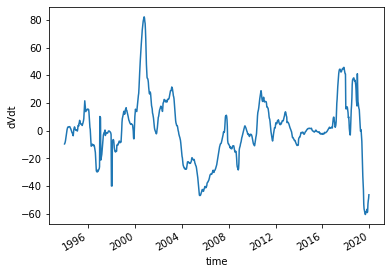

In [56]:
(dVdt_anom_bot/1e6).plot();

### $\Psi$

In [57]:
#remember we're switching signs!
psi_anom_bot = - anom.psi_vel.isel(sigma2_bin=-1) + anom.psi_vel.sel(sigma2_bin=1037.195, method='nearest')
psi_anom_bot.load()

<xarray.DataArray 'psi_vel' (time: 985)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, -1.04940248e+00,
       -1.03339553e+00, -9.02309835e-01, -8.44166458e-01, -8.03508759e-01,
       -9.46183324e-01, -1.08282363e+00, -1.03391683e+00, -1.08036029e+00,
       -1.06351435e+00, -1.11134791e+00, -1.11628401e+00, -1.22516894e+00,
       -1.28085172e+00, -1.26662004e+00, -1.36076462e+00, -1.41210985e+00,
       -1.53233719e+00, -1.92197776e+00, -2.25872922e+00, -2.66874814e+00,
       -3.31190825e+00, -3.53648806e+00, -3.78760648e+00, -3.81087232e+00,
       -3.92251134e+00, -3.92839217e+00, -4.10753632e+00, -4.31665850e+00,
       -4.37404299e+00, -4.59152603e+00, -4.93034935e+00, -5.17137480e+00,
       -5.49849892e+00, -5.82683468e+00, -6.27558374e+00, -6.42160273e+00,
       -6.65338612e+00, -6.80946970e+00, -6.91157389e+00, -7.03228283e+00,
       -7.20408392e+00, -7.32153654e+00, -7.53958321e+00, -7.75828791e+00,
...
        2.37670016e+00,  2.37231755e+00,  2.33782935e+00,  2.50251150e+00,
        2.41171479e+00,  2.37557292e+00,  2.34842300e+00,  2.23883653e+00,
        2.09223104e+00,  2.03883696e+00,  1.97384226e+00,  2.08495975e+00,
        2.11904860e+00,  2.10194945e+00,  2.08423328e+00,  2.08883405e+00,
        2.21157360e+00,  2.33040881e+00,  2.35496116e+00,  2.22205472e+00,
        2.21946001e+00,  2.09119701e+00,  1.87254632e+00,  1.98172915e+00,
        2.39045048e+00,  2.59176803e+00,  2.78328443e+00,  2.66873336e+00,
        2.86570168e+00,  3.33479166e+00,  3.67302966e+00,  3.71201825e+00,
        3.96563458e+00,  4.16641426e+00,  4.84344482e+00,  5.30353403e+00,
        5.84740639e+00,  6.40289259e+00,  6.92448473e+00,  7.00546217e+00,
        7.23184872e+00,  7.52482271e+00,  7.81628180e+00,  8.20574379e+00,
        8.49143219e+00,  8.67103004e+00,  8.78989029e+00,  8.88737583e+00,
        9.01338768e+00,  8.82353878e+00,  9.00963688e+00,  9.03490639e+00,
        9.05485249e+00,  9.04645729e+00,  9.11489296e+00,  9.27919483e+00,
        9.37460136e+00,  9.46288300e+00,  9.54373264e+00,  9.47773933e+00,
        9.12984943e+00,  8.83621216e+00,  8.61234188e+00,  8.57938957e+00,
        8.22787189e+00,  7.59562254e+00,  7.10887384e+00,  7.01673889e+00,
        6.86111259e+00,  6.66494179e+00,  6.12102175e+00,  5.57089329e+00,
        5.16806936e+00,  4.55902624e+00,  4.00230360e+00,  3.85614443e+00,
        3.67143130e+00], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:00:00
    month    (time) int64 1 1 1 2 2 2 3 3 3 4 4 ... 9 9 10 10 10 11 11 11 12 12

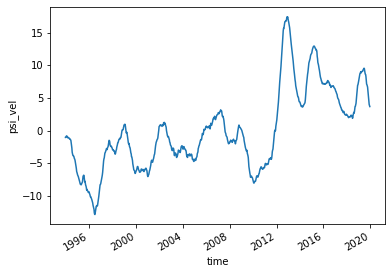

In [58]:
psi_anom_bot.plot();

### $\Omega$

In [59]:
omega_anom_bot = anomaly(omega_bdy)
omega_anom_bot.load()

<xarray.DataArray 'omega_trans' (time: 985)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
       -8.60933710e+00, -8.23242782e+00, -7.54839053e+00, -6.39190381e+00,
       -4.54667648e+00, -2.85337493e+00, -1.35780424e+00,  3.43132391e-01,
        1.91798741e+00,  2.89681317e+00,  3.62620192e+00,  3.70776526e+00,
        3.86727930e+00,  4.05151902e+00,  4.14048662e+00,  4.20476027e+00,
        4.36260197e+00,  4.48171103e+00,  4.09091005e+00,  4.13943901e+00,
        4.00707602e+00,  3.73078414e+00,  3.22960014e+00,  2.49533001e+00,
        2.26042032e+00,  1.56888077e+00,  1.14138044e+00,  5.81925885e-01,
        3.06807074e+00,  5.57576319e+00,  6.80011932e+00,  7.84699638e+00,
        7.64914004e+00,  6.95588837e+00,  6.78970479e+00,  6.65189788e+00,
        6.99743225e+00,  7.03594813e+00,  7.36397832e+00,  6.79951483e+00,
        6.89694775e+00,  8.30307746e+00,  1.09692714e+01,  1.15643414e+01,
...
        4.07638309e+01,  3.96556771e+01,  3.87792962e+01,  3.84824162e+01,
        1.43972976e+01,  1.32275972e+01,  1.41558256e+01,  1.47676764e+01,
        1.51098905e+01,  1.46030416e+01,  1.30620735e+01,  1.09792882e+01,
        7.16201271e+00,  7.83401507e+00,  4.65012496e+00, -5.19687796e-01,
       -3.21799584e+00, -5.36923817e+00, -5.55452730e+00, -1.49622740e-02,
        7.33300750e+00,  1.29121879e+01,  1.66237542e+01,  2.16422267e+01,
        3.07949592e+01,  3.40047887e+01,  3.41709888e+01,  3.50099038e+01,
        3.50037974e+01,  3.47950118e+01,  3.33733162e+01,  3.21895676e+01,
        3.24151423e+01,  3.21674254e+01,  2.99346028e+01,  2.76367189e+01,
        2.31517824e+01,  1.58044781e+01,  1.25509811e+01,  1.07750269e+01,
        3.38487447e+01,  2.38770868e+01,  1.31796718e+01,  1.13177629e+01,
        8.72653983e+00,  7.22855106e+00,  6.46295650e+00,  1.98607577e+00,
       -1.58711344e+00, -6.30174973e+00, -9.53137686e+00, -8.37614063e+00,
       -9.86007096e+00, -1.31890238e+01, -1.69546789e+01, -2.55007144e+01,
       -3.50868274e+01, -4.23249755e+01, -4.72405462e+01, -5.27581047e+01,
       -6.24311985e+01, -6.55215356e+01, -6.62679012e+01, -6.76065257e+01,
       -6.83969750e+01, -6.82509320e+01, -6.70263358e+01, -6.55706969e+01,
       -6.53709010e+01, -6.47854631e+01, -6.29783758e+01, -6.48000959e+01,
       -6.36966163e+01, -5.76593808e+01, -5.46936017e+01, -5.29965626e+01,
       -5.00644137e+01])
Coordinates:
    sigma2_bin  float64 1.037e+03
  * time        (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:0...
    month       (time) int64 1 1 1 2 2 2 3 3 3 4 ... 9 9 10 10 10 11 11 11 12 12

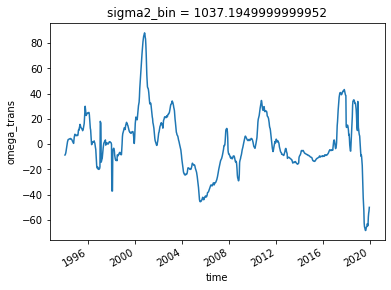

In [60]:
omega_anom_bot.plot();

In [61]:
omega_anom_bot.time

<xarray.DataArray 'time' (time: 985)>
array(['1993-01-07T01:00:00.000000000', '1993-01-17T01:00:00.000000000',
       '1993-01-27T01:00:00.000000000', ..., '2019-11-27T01:00:00.000000000',
       '2019-12-07T01:00:00.000000000', '2019-12-17T01:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    sigma2_bin  float64 1.037e+03
  * time        (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:0...
    month       (time) int64 1 1 1 2 2 2 3 3 3 4 ... 9 9 10 10 10 11 11 11 12 12

In [62]:
anom.time[36]

<xarray.DataArray 'time' ()>
array('1994-01-02T01:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1994-01-02T01:00:00
    month    int64 1

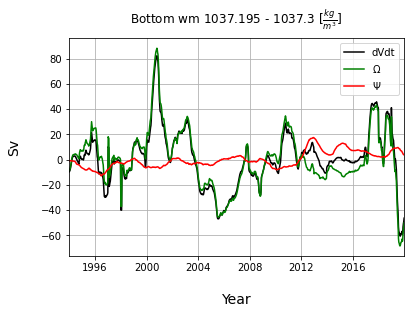

In [63]:
fig, ax1 = plt.subplots()

ax1.plot(anom.time, dVdt_anom_bot/1e6, label='dVdt', color='k')
ax1.plot(anom.time, omega_anom_bot, label=r'$\Omega$', color='green')
ax1.plot(anom.time, psi_anom_bot, label=r'$\Psi$', color='red')
ax1.set_title(r'Bottom wm 1037.195 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
ax1.set_ylabel('Sv', fontsize=14, labelpad=20)
ax1.set_xlabel('Year', fontsize=14, labelpad=20)
ax1.set_xlim(anom.time[36], anom.time[-1]) #1994-2019
ax1.grid()
ax1.legend();

## Indices

In [64]:
soda = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/soda_si_index.zarr'))
sam = xr.open_dataarray('/home/jovyan/WMT-project/Climate-Indices/SAM-index/sam_index')
enso = xr.open_dataarray('/home/jovyan/WMT-project/Climate-Indices/ENSO-index/oni')

In [70]:
soda.time

<xarray.DataArray 'time' (time: 2117)>
array([cftime.DatetimeJulian(1992, 1, 5, 13, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1992, 1, 10, 13, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1992, 1, 15, 13, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeJulian(2020, 12, 13, 13, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2020, 12, 18, 13, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2020, 12, 23, 13, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
    month    (time) int64 dask.array<chunksize=(2117,), meta=np.ndarray>
  * time     (time) object 1992-01-05 13:00:00 ... 2020-12-23 13:00:00
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time

In [78]:
soda_monthly = soda.resample(time='MS').mean()
enso_soda_time = enso.sel(time=slice('1992','2020'))
sam_soda_time = sam.sel(time=slice('1992','2020')).assign_coords(coords={'time':enso_soda_time.time})

In [92]:
soda_monthly['time'] = soda_monthly.indexes['time'].to_datetimeindex()

In [93]:
indices = xr.merge([soda_monthly.soda_si_index.rename('soda'), 
                    enso_soda_time.drop('month').rename('enso'), 
                    sam_soda_time.drop('month').rename('sam')])

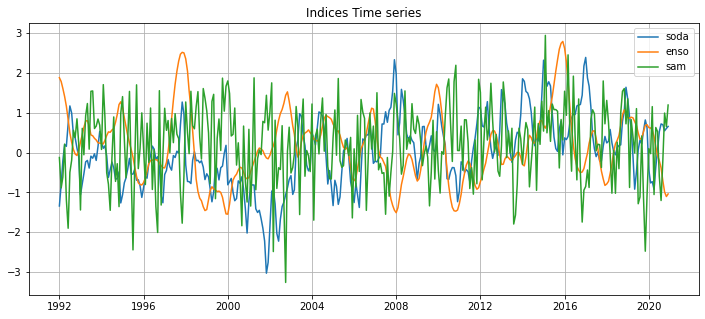

In [94]:
fig, ax = plt.subplots(figsize=(12,5))
for i in indices.variables:
    if i =='time':
        continue
    ax.plot(indices.time, indices[i], label=f'{indices[i].name}')
    
plt.legend()
plt.grid()
plt.title('Indices Time series');

## Heat map of Corralation matrices

In [95]:
import seaborn as sn

In [96]:
indices_df = indices.to_dataframe()
indices_df.head()

,soda,enso,sam
time,,,
1992-01-01,-1.339931,1.883747,-0.122525
1992-02-01,-0.794786,1.786449,-0.885817
1992-03-01,-0.203645,1.614739,-0.616002
1992-04-01,0.205116,1.408937,0.213964
1992-05-01,0.159171,1.166296,-1.179878


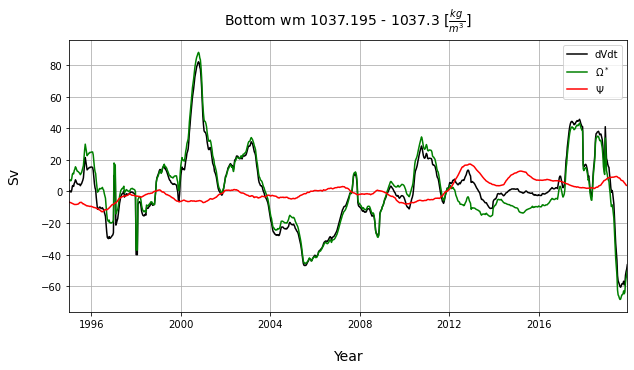

In [98]:
fig = plt.subplots(figsize=(10,5))
plt.plot(dVdt_anom_bot.time, dVdt_anom_bot/1e6, label='dVdt', color='k')
plt.plot(omega_anom_bot.time, omega_anom_bot, label=r'$\Omega^*$', color='green')
plt.plot(psi_anom_bot.time, psi_anom_bot, label=r'$\Psi$', color='red')
plt.title(r'Bottom wm 1037.195 - 1037.3 [$\frac{kg}{m^3}$]', fontsize=14, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.xlim(dVdt_anom_bot.time[73], dVdt_anom_bot.time[-1]) #2007-2010

plt.legend()
plt.grid();

In [106]:
ds_unresampled = xr.merge([dVdt_anom_bot.rename('dvdt'), 
                           psi_anom_bot.rename('psi'), 
                           omega_anom_bot.rename('omega')]).drop(['month','sigma2_bin'])
ds = ds_unresampled.resample(time='MS').mean()

In [107]:
ds.coords

Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2019-12-01

In [103]:
indices.coords

Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

In [108]:
budget_df = ds.to_dataframe()

In [109]:
budget_df.tail()

,dvdt,psi,omega
time,,,
2019-08-01,-5.994997e+07,8.134295,-68.084811
2019-09-01,-5.899319e+07,6.995575,-65.989311
2019-10-01,-5.806848e+07,6.118952,-64.187978
2019-11-01,-5.410619e+07,4.576466,-58.683200
2019-12-01,-4.776615e+07,3.763788,-51.530488


### Correlation matrix of all terms (budget & indices)

In [111]:
import pandas as pd

In [112]:
budget_ind = pd.concat([budget_df, indices_df], axis=1)
budget_ind.tail()

,dvdt,psi,omega,soda,enso,sam
time,,,,,,
2020-08-01,NaN,NaN,NaN,0.721856,-0.383115,-1.201919
2020-09-01,NaN,NaN,NaN,0.702181,-0.710986,-0.175974
2020-10-01,NaN,NaN,NaN,0.549043,-0.988256,0.994549
2020-11-01,NaN,NaN,NaN,0.608854,-1.101873,0.653681
2020-12-01,NaN,NaN,NaN,0.659053,-1.036802,1.196730


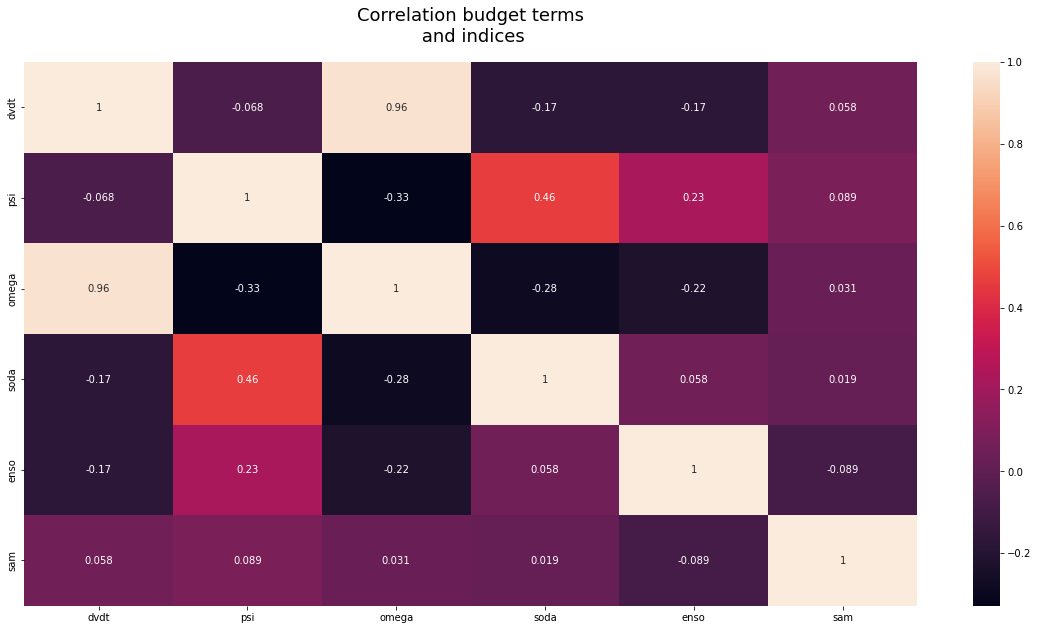

In [113]:
plt.figure(figsize=(20,10))
sn.heatmap(budget_ind.corr(), annot=True)
plt.title('Correlation budget terms\n and indices', fontsize=18, pad=20.5);